In [9]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import colors, cm
from astropy.io import fits, ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import default_cosmology
import glob

In [8]:
lcdm = default_cosmology.get()

In [10]:
sdss = ascii.read('sdss_catalog.csv')

In [14]:
grpcat = fits.open('grp_cat.fits')[1].data

In [15]:
ptsrc = fits.open('ptsrc_cat.fits')[1].data
ptsrc_lowsig = fits.open('ptsrc_lowsig.fits')[1].data

In [37]:
def make_regions(catalog, type='grp', maskrad_kpc=None, shape='circle'):
    output = []
    if type == 'gal':
        ra = catalog['ra']*u.degree
        dec = catalog['dec']*u.degree
    elif type in ['grp', 'pts']:
        ra = catalog['RA']*u.degree
        dec = catalog['DEC']*u.degree
    else:
        print('Invalid type')
    if type == 'pts':
        rad = catalog['APE_RADIUS_s']*4*u.arcsec.to('arcmin')
    elif type == 'grp':
        rad = catalog['R_SNR_MAX_ARCMIN']*u.arcmin.to('arcmin')
    else: 
        dA = lcdm.angular_diameter_distance(catalog['redshift'])
        rad = maskrad_kpc/dA * u.radian.to('arcmin')
    for (x, y, l) in zip(ra, dec, rad):
        c = SkyCoord(x, y)
        if shape == 'circle':
            output.append(shape+"(%s,%0.5f')" % (c.to_string('hmsdms'),l))
        elif shape == 'annulus':
            output.append(shape+"(%s,%0.5f',%0.5f')" % (c.to_string('hmsdms'),1.5*l, 2.5*l))
        else:
            print('Invalid shape')
    return output

In [38]:
grpmask = make_regions(grpcat, type='grp', shape='circle')

In [39]:
ptsmask = make_regions(ptsrc, type='pts', shape='circle')

In [40]:
ptsmask_lowsig = make_regions(ptsrc_lowsig, type='pts')

In [47]:
mass0 = [(sdss['logMass'] < 10.2)]
mass1 = [(sdss['logMass'] > 10.2)*(sdss['logMass'] < 10.7)]
mass2 = [(sdss['logMass'] > 10.7)*(sdss['logMass'] < 11.2)]
mass3 = [(sdss['logMass'] > 11.2)*(sdss['logMass'] < 11.7)]
mass4 = [(sdss['logMass'] > 11.7)]
len(sdss[mass0]), len(sdss[mass1]), len(sdss[mass2]), len(sdss[mass3]), len(sdss[mass4])

(1371, 1482, 1161, 177, 3)

In [50]:
ssfr = 10**(sdss['ssfr'] - 9) #to go from Gyr^-1 to yr^-1
ssfr.min(), ssfr.max(), ssfr.mean(), np.median(ssfr), np.std(ssfr)

(1e-42,
 5.213192710430113e-10,
 9.866869745258481e-11,
 3.5342234815200725e-11,
 1.3967821306190154e-10)

Text(0, 0.5, 'N')

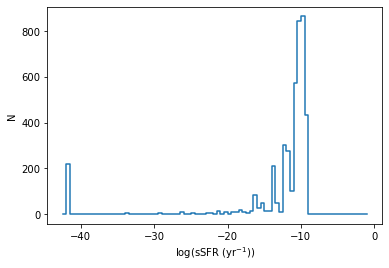

In [62]:
hist, bins = np.histogram(np.log10(ssfr), bins=84, range=(-43,-1))
plt.step(bins[1:], hist)
plt.xlabel(r'log(sSFR (yr$^{-1}$))')
plt.ylabel('N')

Text(0, 0.5, 'N')

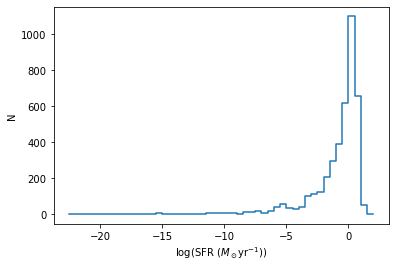

In [63]:
hist, bins = np.histogram(np.log10(ssfr*10**sdss['logMass']), bins=50, range=(-23,2))
plt.step(bins[1:], hist)
bins[np.argmax(hist)]
plt.xlabel(r'log(SFR ($M_\odot \rm yr^{-1}$))')
plt.ylabel('N')

Text(0, 0.5, 'N')

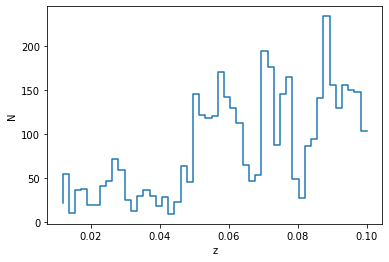

In [66]:
hist, bins = np.histogram(sdss['redshift'], bins=50)
plt.step(bins[1:], hist)
bins[np.argmax(hist)]
plt.xlabel(r'z')
plt.ylabel('N')

Text(0.5, 0, 'g')

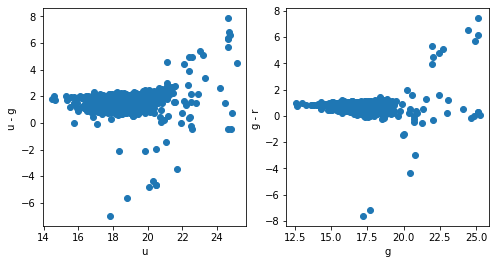

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(8,4))
ax1.scatter( sdss['u'],sdss['u'] - sdss['g'])
ax1.set_ylabel('u - g ')
ax1.set_xlabel('u')
ax2.scatter( sdss['g'],sdss['g'] - sdss['r'])
ax2.set_ylabel('g - r ')
ax2.set_xlabel('g')

Text(0, 0.5, 'N')

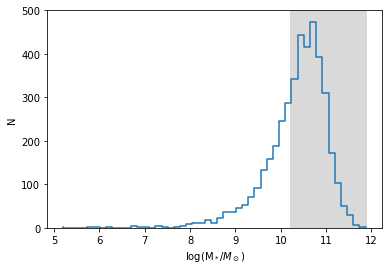

In [88]:
hist, bins = np.histogram(sdss['logMass'], bins=50)
plt.step(bins[1:], hist)
plt.bar(10.2, 500, 1.7, color='k', alpha=0.15, align='edge')
plt.ylim(0,500)
plt.xlabel(r'log(M$_*/M_\odot$)')
plt.ylabel('N')

In [101]:
grpoutput = []
for line in grpmask:
    grpoutput.append (line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))

ptoutput = []
for line in ptsmask:
    ptoutput.append(line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))
    
ptoutput_lowsig = []
for line in ptsmask_lowsig:
    ptoutput_lowsig.append(line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))

In [106]:
with open('grp_cat.reg','w') as f:
    f.writelines(grpoutput)
    
with open('ptsrc_cat.reg','w') as f:
    f.writelines(ptoutput)
    
with open('ptsrc_cat_lowsig.reg','w') as f:
    f.writelines(ptoutput_lowsig)